In [2]:
# Tensorflow imports
# from tensorflow.test import is_gpu_available
from tensorflow.keras.models import Sequential, load_model, model_from_json, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers, regularizers

# Sklearn imports
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Mongo
from pymongo import MongoClient

# Pandas and numpy
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 4)})

# Other
from scipy.ndimage.filters import gaussian_filter1d
from IPython.display import Image
from datetime import datetime, timedelta
from math import sqrt

import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

In [3]:
sns.set(rc={'figure.figsize':(18, 4)})

### Connect to mongo database

In [226]:
# Mongo client
client = MongoClient('mongodb://165.22.199.122:27017')
db = client.processed
data = db.internal

In [227]:
df['price'].head()

timestamp
2019-11-03 15:02:00    9193.544
2019-11-03 15:04:00    9190.258
2019-11-03 15:06:00    9186.290
2019-11-03 15:08:00    9186.683
2019-11-03 15:10:00    9190.851
Name: price, dtype: float64

In [230]:
# Load the data
df= (pd.DataFrame(list(data.find()))
    .drop(['_id', 'window'], 1)
    .set_index('timestamp')
    .sort_index()
    .dropna())

df['price_diff'] = df['price'].diff(1)
df = df.dropna()
# df = df[df['price_diff'].abs() < 40]
# df = df[df['n_tweets'] >= 190]
# df = df.iloc[5:-5]

print(df.shape)
df.head()

(5322, 4)


,n_tweets,price,sentiment,price_diff
timestamp,,,,
2019-11-03 14:46:00,73,9183.607500,0.241125,-3.022500
2019-11-03 14:48:00,126,9182.878333,0.255345,-0.729167
2019-11-03 14:50:00,184,9181.015000,0.253839,-1.863333
2019-11-03 14:52:00,257,9184.389000,0.216775,3.374000
2019-11-03 14:54:00,311,9186.677000,0.211572,2.288000


### Function to create timeline plot

In [231]:
def plot_timeline(first_feature, second_feature):
    sns.set_style("dark")
    
    fig, ax1 = plt.subplots()

    ax1.plot(df['2019-01-02 08:00:00':][first_feature], label=first_feature)
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx()
    ax2.plot(df['2019-01-02 08:00:00':][second_feature], color='orange', label=second_feature)
    ax2.legend(loc='upper right')

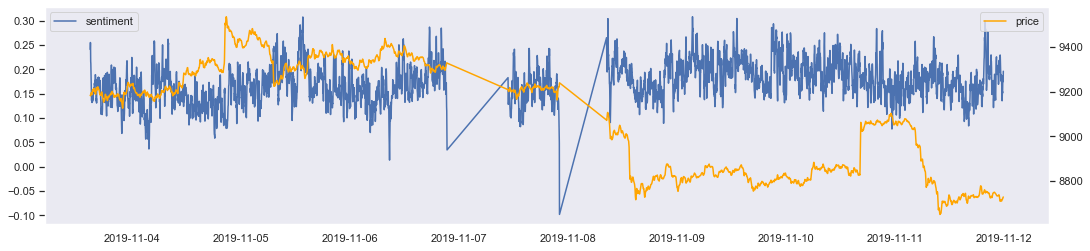

In [232]:
plot_timeline('sentiment', 'price')

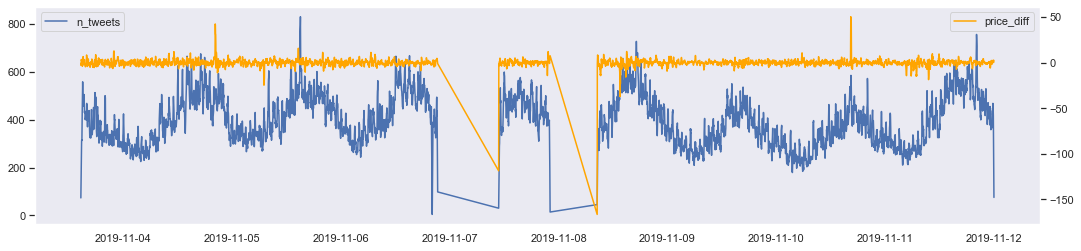

In [233]:
plot_timeline('n_tweets', 'price_diff')

### Prepare training data

In [240]:
df['price_diff'].head(25)

timestamp
2019-11-03 14:46:00   -3.022500
2019-11-03 14:48:00   -0.729167
2019-11-03 14:50:00   -1.863333
2019-11-03 14:52:00    3.374000
2019-11-03 14:54:00    2.288000
2019-11-03 14:56:00    2.502000
2019-11-03 14:58:00    2.921000
2019-11-03 15:00:00    3.374000
2019-11-03 15:02:00   -1.930000
2019-11-03 15:04:00   -3.286000
2019-11-03 15:06:00   -3.968000
2019-11-03 15:08:00    0.393000
2019-11-03 15:10:00    4.168000
2019-11-03 15:12:00    4.188000
2019-11-03 15:14:00    5.621000
2019-11-03 15:16:00    6.602000
2019-11-03 15:18:00    0.556000
2019-11-03 15:20:00   -2.253000
2019-11-03 15:22:00   -2.285000
2019-11-03 15:24:00   -2.369000
2019-11-03 15:26:00    2.294000
2019-11-03 15:28:00    3.392000
2019-11-03 15:30:00    1.887000
2019-11-03 15:32:00    2.866000
2019-11-03 15:34:00    3.337000
Name: price_diff, dtype: float64

In [235]:
split_sequence(df['price'], 3)

array([[9183.6075    , 9182.87833333, 9181.015     ],
       [9182.87833333, 9181.015     , 9184.389     ],
       [9181.015     , 9184.389     , 9186.677     ],
       ...,
       [8719.915     , 8722.221     , 8724.388     ],
       [8722.221     , 8724.388     , 8727.061     ],
       [8724.388     , 8727.061     , 8728.058     ]])

In [236]:
train_size = int(.75 * len(df))

price_diff = df['price_diff'].values
price_diff_train, price_diff_test = price_diff[:train_size], price_diff[train_size:]

sentiment = df['sentiment'].values
sentiment_train, sentiment_test = sentiment[:train_size], sentiment[train_size:]

n_tweets = df['n_tweets'].values
n_tweets_train, n_tweets_test = n_tweets[:train_size], n_tweets[train_size:]

data = np.stack([price_diff_train, sentiment_train, n_tweets_train], axis=1)

data_split = split_sequence(data, 12)

In [237]:
np.set_printoptions(suppress=True)
data_split[0]

array([[ -3.0225    ,   0.24112466,  73.        ],
       [ -0.72916667,   0.25534524, 126.        ],
       [ -1.86333333,   0.25383859, 184.        ],
       [  3.374     ,   0.21677549, 257.        ],
       [  2.288     ,   0.21157235, 311.        ],
       [  2.502     ,   0.19037853, 312.        ],
       [  2.921     ,   0.17361044, 316.        ],
       [  3.374     ,   0.16318371, 313.        ],
       [ -1.93      ,   0.15191169, 385.        ],
       [ -3.286     ,   0.13599184, 429.        ],
       [ -3.968     ,   0.1452315 , 473.        ],
       [  0.393     ,   0.1468129 , 504.        ]])

In [238]:
data_split[0].flatten('F')

array([ -3.0225    ,  -0.72916667,  -1.86333333,   3.374     ,
         2.288     ,   2.502     ,   2.921     ,   3.374     ,
        -1.93      ,  -3.286     ,  -3.968     ,   0.393     ,
         0.24112466,   0.25534524,   0.25383859,   0.21677549,
         0.21157235,   0.19037853,   0.17361044,   0.16318371,
         0.15191169,   0.13599184,   0.1452315 ,   0.1468129 ,
        73.        , 126.        , 184.        , 257.        ,
       311.        , 312.        , 316.        , 313.        ,
       385.        , 429.        , 473.        , 504.        ])

In [167]:
data_split.reshape(-1, 12*3, order='F')[0]

array([ -1.93      ,  -3.286     ,  -3.968     ,   0.393     ,
         4.168     ,   4.188     ,   5.621     ,   6.602     ,
         0.556     ,  -2.253     ,  -2.285     ,  -2.369     ,
         0.15191169,   0.13599184,   0.1452315 ,   0.1468129 ,
         0.13215627,   0.14367148,   0.15276477,   0.13937879,
         0.1348307 ,   0.14266518,   0.13861673,   0.15006024,
       385.        , 429.        , 473.        , 504.        ,
       558.        , 512.        , 474.        , 462.        ,
       456.        , 471.        , 490.        , 503.        ])

In [242]:
def split_sequence(sequence, n_steps):
    X = []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
        
    return np.array(X)

def generate_train_test(n_steps=12, train_size=.75, flatten=True):
    train_size = int(train_size * len(df))
    
    prices = df['price'].values
    prices_train, prices_test = prices[:train_size], prices[train_size:]
    
    price_diff = df['price_diff'].values
    price_diff_train, price_diff_test = price_diff[:train_size], price_diff[train_size:]
    
    sentiment = df['sentiment'].values
    sentiment_train, sentiment_test = sentiment[:train_size], sentiment[train_size:]
    
    n_tweets = df['n_tweets'].values
    n_tweets_train, n_tweets_test = n_tweets[:train_size], n_tweets[train_size:]
    
    train = np.stack([price_diff_train, sentiment_train, n_tweets_train], axis=1)
    test = np.stack([price_diff_test, sentiment_test, n_tweets_test], axis=1)
    
    # Scale the data
    scaler = StandardScaler()
#     train_scaled = scaler.fit_transform(train)
#     test_scaled = scaler.transform(test)
    train_scaled = train
    test_scaled = test
    
    # Create the sequence
    X_train = split_sequence(train_scaled, n_steps)
    X_test = split_sequence(test_scaled, n_steps)
    
    y_prices = df['price_diff']

    y_train = y_prices.iloc[n_steps:len(X_train)+n_steps].values
    y_test = y_prices.iloc[-len(X_test):].values
    
    # Flatten the timeseries
    if flatten:
        X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2], order='F')
        X_test = X_test.reshape(-1, X_test.shape[1]*X_test.shape[2], order='F')
        
    return X_train, X_test, y_train, y_test

In [243]:
X_train, X_test, y_train, y_test = generate_train_test(n_steps=12, flatten=True)
X_train.shape

(3979, 36)

In [244]:
X_train[0]

array([ -3.0225    ,  -0.72916667,  -1.86333333,   3.374     ,
         2.288     ,   2.502     ,   2.921     ,   3.374     ,
        -1.93      ,  -3.286     ,  -3.968     ,   0.393     ,
         0.24112466,   0.25534524,   0.25383859,   0.21677549,
         0.21157235,   0.19037853,   0.17361044,   0.16318371,
         0.15191169,   0.13599184,   0.1452315 ,   0.1468129 ,
        73.        , 126.        , 184.        , 257.        ,
       311.        , 312.        , 316.        , 313.        ,
       385.        , 429.        , 473.        , 504.        ])

In [245]:
y_train[0]

4.167999999997846

### Build the keras model

In [195]:
# model.add(BatchNormalization())
# model.add(Dropout(.65))
# model.add(Dense(41, activation='relu'))
# model.add(LSTM(32, activation='relu'))
# model.add(LSTM(64, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))

In [196]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def build_lstm_model():
    model = Sequential()
    
    model.add(LSTM(32, activation='relu', input_shape=(3, 4)))
    model.add(Dense(16, activation='relu'))
    
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss=root_mean_squared_error)
    
    return model

def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],), 
#                     kernel_regularizer=regularizers.l2(0.01)
                   ))
    
    model.add(Dense(32, activation='relu', 
#                     kernel_regularizer=regularizers.l2(0.01)
                   ))
        
    model.add(Dense(1))
    model.compile(optimizer='adam', loss=root_mean_squared_error)
    
    return model

In [224]:
model.layers[0].get_weights()

[array([[ 0.11190651,  0.20418186,  0.2243125 , ...,  0.01880236,
         -0.02919756, -0.01506677],
        [-0.03580019,  0.08305179, -0.0429619 , ...,  0.06555004,
          0.12700327,  0.04015161],
        [ 0.07328297, -0.24461813, -0.13823096, ..., -0.39205742,
         -0.12753464,  0.07316528],
        ...,
        [-0.00187542, -0.14753875,  0.1095631 , ...,  0.0949029 ,
         -0.14030576, -0.06267226],
        [-0.16887733, -0.14496237,  0.15108623, ..., -0.13155855,
         -0.05238795, -0.11270608],
        [ 0.10344909, -0.0203429 , -0.24299495, ...,  0.21360014,
          0.10822363, -0.15515709]], dtype=float32),
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.00373744, -0.01386631, -0.02361398, -0.01635803,
        -0.00301559,  0.        , -0.01962764,  0.        , -0.00371354,
        -0.01607416,  0.01798762, -0.02586942, -0.0266962 ,  0.        ,
         0.00790101, -0.00222529,  0.00084596,  0.        , -0.022

In [197]:
# Create the model
model = build_model()

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=32)

# Checkpoints
checkpointer = ModelCheckpoint(filepath='models/keras_weights.hdf5',
                                   verbose=1,
                                   save_best_only=True)

# Fit the model
model.fit(
    X_train, 
    y_train, 
    validation_split=0.33,
    epochs=256, 
    batch_size=64,
    callbacks=[checkpointer, early_stopping]);

Train on 2645 samples, validate on 1304 samples
Epoch 1/256
2112/2645 [======================>.......] - ETA: 0s - loss: 44.0840  
Epoch 00001: val_loss improved from inf to 8.16126, saving model to models/keras_weights.hdf5
2645/2645 [==============================] - 1s 216us/sample - loss: 37.5712 - val_loss: 8.1613
Epoch 2/256
2304/2645 [=========================>....] - ETA: 0s - loss: 5.7152 
Epoch 00002: val_loss improved from 8.16126 to 4.10781, saving model to models/keras_weights.hdf5
2645/2645 [==============================] - 0s 46us/sample - loss: 5.6050 - val_loss: 4.1078
Epoch 3/256
2624/2645 [============================>.] - ETA: 0s - loss: 3.4894
Epoch 00003: val_loss improved from 4.10781 to 3.20713, saving model to models/keras_weights.hdf5
2645/2645 [==============================] - 0s 40us/sample - loss: 3.4811 - val_loss: 3.2071
Epoch 4/256
1792/2645 [===================>..........] - ETA: 0s - loss: 3.0735
Epoch 00004: val_loss improved from 3.20713 to 2.77643

Epoch 70/256
  64/2645 [..............................] - ETA: 0s - loss: 1.3249
Epoch 00070: val_loss did not improve from 1.42160
2645/2645 [==============================] - 0s 32us/sample - loss: 1.7988 - val_loss: 1.5867
Epoch 71/256
2624/2645 [============================>.] - ETA: 0s - loss: 2.0102
Epoch 00071: val_loss did not improve from 1.42160
2645/2645 [==============================] - 0s 32us/sample - loss: 2.0331 - val_loss: 2.8636
Epoch 72/256
2176/2645 [=======================>......] - ETA: 0s - loss: 2.0468
Epoch 00072: val_loss did not improve from 1.42160
2645/2645 [==============================] - 0s 39us/sample - loss: 1.9976 - val_loss: 1.4571
Epoch 73/256
1984/2645 [=====================>........] - ETA: 0s - loss: 1.7264
Epoch 00073: val_loss improved from 1.42160 to 1.41748, saving model to models/keras_weights.hdf5
2645/2645 [==============================] - 0s 56us/sample - loss: 1.7013 - val_loss: 1.4175
Epoch 74/256
1984/2645 [=====================>...

Epoch 106/256
1792/2645 [===================>..........] - ETA: 0s - loss: 1.8596
Epoch 00106: val_loss did not improve from 1.40800
2645/2645 [==============================] - 0s 48us/sample - loss: 1.8572 - val_loss: 1.5998
Epoch 107/256
1728/2645 [==================>...........] - ETA: 0s - loss: 1.6800
Epoch 00107: val_loss did not improve from 1.40800
2645/2645 [==============================] - 0s 43us/sample - loss: 1.6981 - val_loss: 1.5031
Epoch 108/256
2240/2645 [========================>.....] - ETA: 0s - loss: 1.6738
Epoch 00108: val_loss did not improve from 1.40800
2645/2645 [==============================] - 0s 42us/sample - loss: 1.6373 - val_loss: 1.4099
Epoch 109/256
1920/2645 [====================>.........] - ETA: 0s - loss: 1.7672
Epoch 00109: val_loss did not improve from 1.40800
2645/2645 [==============================] - 0s 39us/sample - loss: 1.7022 - val_loss: 1.4226
Epoch 110/256
2176/2645 [=======================>......] - ETA: 0s - loss: 1.6687
Epoch 0011

2645/2645 [==============================] - 0s 47us/sample - loss: 1.6635 - val_loss: 1.3900
Epoch 142/256
2432/2645 [==========================>...] - ETA: 0s - loss: 1.6469
Epoch 00142: val_loss did not improve from 1.38996
2645/2645 [==============================] - 0s 34us/sample - loss: 1.6494 - val_loss: 1.9348
Epoch 143/256
  64/2645 [..............................] - ETA: 0s - loss: 2.0712
Epoch 00143: val_loss did not improve from 1.38996
2645/2645 [==============================] - 0s 27us/sample - loss: 1.6951 - val_loss: 1.6465
Epoch 144/256
  64/2645 [..............................] - ETA: 0s - loss: 2.2742
Epoch 00144: val_loss did not improve from 1.38996
2645/2645 [==============================] - 0s 28us/sample - loss: 1.8471 - val_loss: 1.4803
Epoch 145/256
2624/2645 [============================>.] - ETA: 0s - loss: 1.7710
Epoch 00145: val_loss did not improve from 1.38996
2645/2645 [==============================] - 0s 31us/sample - loss: 1.7685 - val_loss: 1.739

### Load model

In [218]:
def load_trained_model():
    model = build_model()
    model.load_weights('models/keras_weights.hdf5')
    
    return model

model = load_trained_model()

#### Baseline functions
* Roll - always predict previous price
* Zero - always predict zero

In [219]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def predict_roll(data):
    return sqrt(mean_squared_error(np.roll(data, 1)[1:], data[1:]))

def predict_zero(data):
    return sqrt(mean_squared_error(np.zeros_like(data), data))

In [241]:
X_train[0]

array([ -1.93      ,  -3.286     ,  -3.968     ,   0.393     ,
         4.168     ,   4.188     ,   5.621     ,   6.602     ,
         0.556     ,  -2.253     ,  -2.285     ,  -2.369     ,
         0.15191169,   0.13599184,   0.1452315 ,   0.1468129 ,
         0.13215627,   0.14367148,   0.15276477,   0.13937879,
         0.1348307 ,   0.14266518,   0.13861673,   0.15006024,
       385.        , 429.        , 473.        , 504.        ,
       558.        , 512.        , 474.        , 462.        ,
       456.        , 471.        , 490.        , 503.        ])

In [221]:
y_train[0]

2.293999999999869

In [223]:
y_hat[0]

array([3.075073], dtype=float32)

In [222]:
# Predict using the test data
y_hat = model.predict(X_test)
y_hat_train = model.predict(X_train)

In [201]:
# Test baseline
print('Test baseline roll: ${:.2f}'.format(predict_roll(y_test)))
print('Test baseline zero: ${:.2f}'.format(predict_zero(y_test)))
print('Test RMSE: ${:.2f}'.format(rmse(y_hat, y_test)))

Test baseline roll: $1.95
Test baseline zero: $3.06
Test RMSE: $1.67


In [202]:
# Train baseline
print('Train baseline roll: ${:.2f}'.format(predict_roll(y_train)))
print('Train baseline zero: ${:.2f}'.format(predict_zero(y_train)))
print('Train RMSE: ${:.2f}'.format(rmse(y_hat_train, y_train)))

Train baseline roll: $1.97
Train baseline zero: $3.28
Train RMSE: $1.61


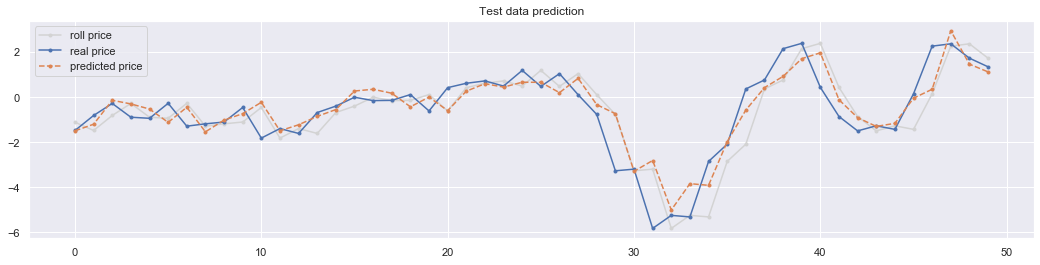

In [203]:
sns.set(style='darkgrid')
plt.plot(np.roll(y_test, 1)[-50:], label='roll price', color='lightgray', marker='o', markersize=3)
plt.plot(y_test[-50:], label='real price', marker='o', markersize=3)
plt.plot(y_hat[-50:], linestyle='dashed', label='predicted price', marker='o', markersize=3)
plt.title('Test data prediction')
plt.legend();

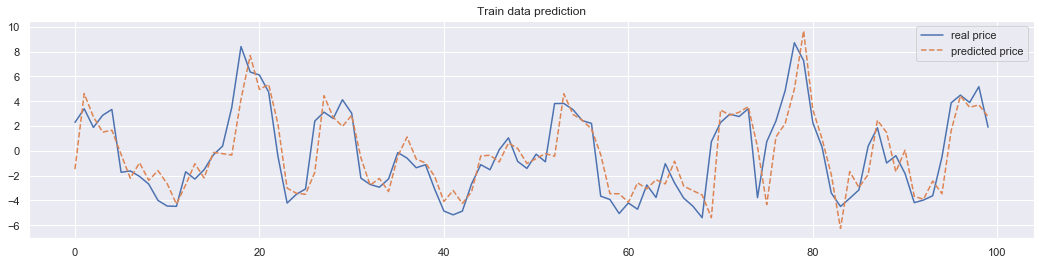

In [204]:
sns.set(style='darkgrid')
plt.plot(y_train[:100], label='real price')
plt.plot(y_hat_train[:100], linestyle='dashed', label='predicted price')
plt.title('Train data prediction')
plt.legend();

### XGBoost

In [307]:
from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, space_eval, rand

In [281]:
# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'objective':        'reg:squarederror',
    'n_estimators':     10000
}

xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}

xgb_data_params = {
    'n_steps': hp.choice('n_steps', np.arange(1, 24, 1, dtype=int)),
}

xgb_parameters = dict()
xgb_parameters['reg_params']  = xgb_reg_params
xgb_parameters['fit_params']  = xgb_fit_params
xgb_parameters['data_params'] = xgb_data_params

In [282]:
class Hyperopt():
    
    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            print({'status': STATUS_FAIL, 'exception': str(e)})
        else:
            return result, trials

    def xgb_regression(self, parameters):
        model = XGBRegressor(**parameters['reg_params'])
        return self.train(model, parameters)

    def train(self, model, parameters):
        X_train, X_test, y_train, y_test = generate_train_test(**parameters['data_params'])
        
        model.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                **parameters['fit_params'])
        
        y_hat = model.predict(X_test)
        loss = np.sqrt(mean_squared_error(y_test, y_hat))
        
        return {'loss': loss, 'status': STATUS_OK, 'model': model}

In [308]:
optimizer = Hyperopt()

best, trails = optimizer.process(
    fn_name='xgb_regression', 
    space=xgb_parameters, 
    trials=Trials(), 
    algo=rand.suggest,
    max_evals=20)

100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [01:29<00:00,  2.88s/it, best loss: 38.095362672543025]


In [309]:
def get_best_model(trails):
    best_idx = np.argmin([trail['result']['loss'] for trail in trails])
    return list(trails)[best_idx]['result']['model']

def get_best_data_params(parameters, best_params):
    return space_eval(parameters, best_params)['data_params']

In [310]:
data_params = get_best_data_params(xgb_parameters, best)

X_train, X_test, y_train, y_test = generate_train_test(**data_params)

In [311]:
xgboost = get_best_model(trails)

In [312]:
# Predict using the test data
y_hat = xgboost.predict(X_test)
y_hat_train = xgboost.predict(X_train)

In [313]:
# Test baseline
print('Test baseline roll: ${:.2f}'.format(predict_roll(y_test)))
print('Test baseline zero: ${:.2f}'.format(predict_zero(y_test)))
print('Test RMSE: ${:.2f}'.format(rmse(y_hat, y_test)))

Test baseline roll: $34.88
Test baseline zero: $5327.72
Test RMSE: $38.10


In [314]:
# Train baseline
print('Train baseline roll: ${:.2f}'.format(predict_roll(y_train)))
print('Train baseline zero: ${:.2f}'.format(predict_zero(y_train)))
print('Train RMSE: ${:.2f}'.format(rmse(y_hat_train, y_train)))

Train baseline roll: $116.47
Train baseline zero: $8599.96
Train RMSE: $76.55


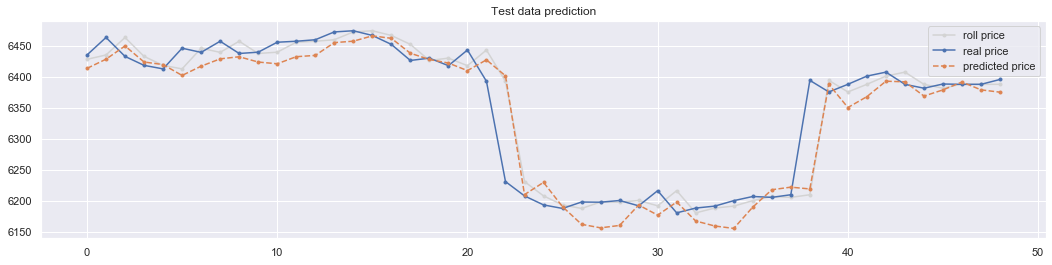

In [315]:
plt.plot(np.roll(y_test, 1)[1:50], label='roll price', color='lightgray', marker='o', markersize=3)
plt.plot(y_test[1:50], label='real price', marker='o', markersize=3)
plt.plot(y_hat[1:50], linestyle='dashed', label='predicted price', marker='o', markersize=3)
plt.title('Test data prediction')
plt.legend();

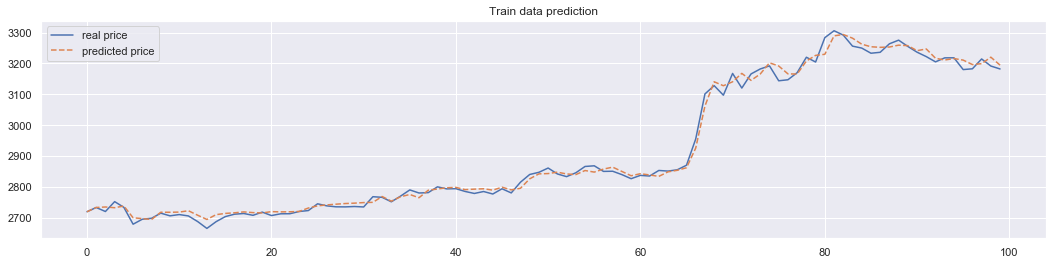

In [316]:
plt.plot(y_train[:100], label='real price')
plt.plot(y_hat_train[:100], linestyle='dashed', label='predicted price')
plt.title('Train data prediction')
plt.legend();